# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
# from tensorflow.keras.applications import vgg16
# from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.applications import resnet50
# from tensorflow.keras.applications.resnet import ResNet152V2

print(tf.__version__)
print(tf.executing_eagerly())

2.14.0
True


In [2]:
from tensorflow.keras.applications import EfficientNetV2L

In [3]:
import os
from random import shuffle
from glob import glob

In [4]:
cur_path = os.getcwd()
path = cur_path + '/data'
if not os.path.exists(path):
  os.makedirs(path)

In [6]:
from cats_and_dogs_download_dataset_from_kaggle_v2 import download_dataset

In [7]:
download_dataset()

In [8]:
!unzip -qo /content/data/dogs-vs-cats-redux-kernels-edition.zip -d /content/data
!unzip -qo /content/data/train.zip -d /content/data
!unzip -qo /content/data/test.zip -d /content/data

## Функции загрузки данных

In [9]:
os.getcwd()

'/content/data'

In [10]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/data/train/*.jpg')
test_files = glob('/content/data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return img

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [11]:
len(train_files)

25000

## Визуализируем примеры для обучения

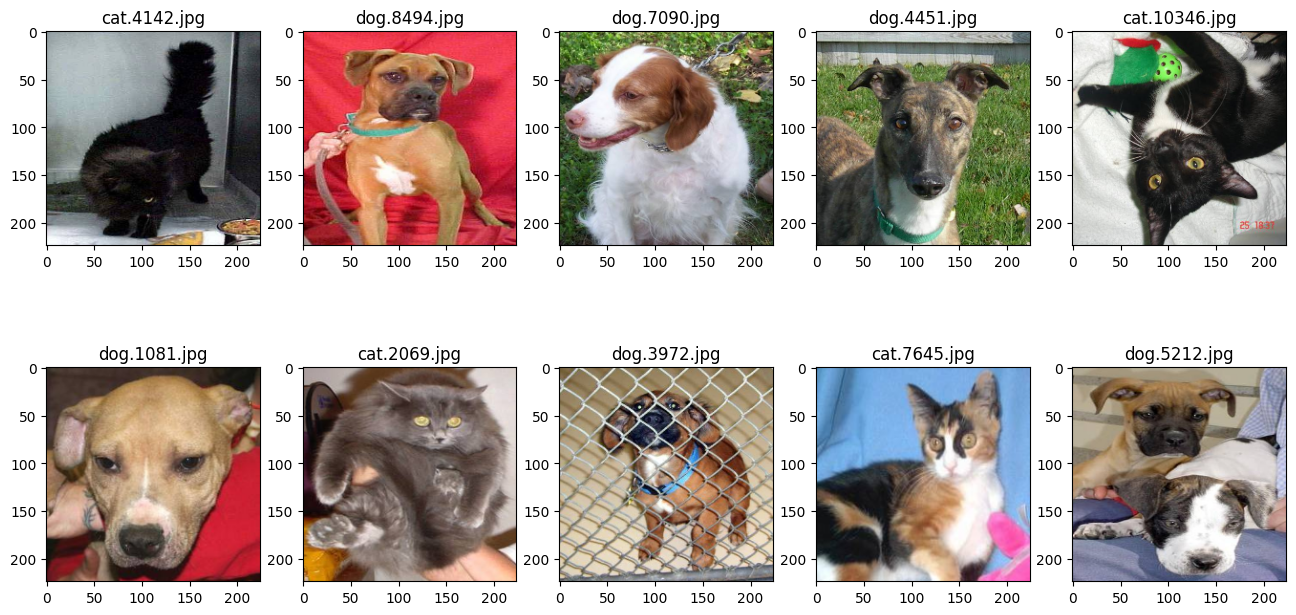

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [17]:
base_model = EfficientNetV2L( weights='imagenet',
                                include_top=False,
                                input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

473176280/473176280 [==============================] - 3s 0us/step


In [18]:
base_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                

## Добавляем полносвязный слой

In [19]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = base_model.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid')(x)  # функция активации

model = tf.keras.Model(base_model.input, x)

## Выводим архитектуру модели

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                           

## Компилируем модель и запускаем обучение

In [21]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy
              metrics=['accuracy'])

In [22]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          # batch_size = 64,
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 62s 2s/step - loss: 0.1454 - accuracy: 0.9328 - val_loss: 0.0422 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 8s 773ms/step - loss: 0.0684 - accuracy: 0.9812 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 8s 798ms/step - loss: 0.0401 - accuracy: 0.9906 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 8s 798ms/step - loss: 0.0294 - accuracy: 0.9891 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 8s 830ms/step - loss: 0.0305 - accuracy: 0.9922 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 8s 824ms/step - loss: 0.0303 - accuracy: 0.9891 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 8s 853ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0229 - val_accuracy: 1.0000
E

In [24]:
model.history

In [25]:
model.save('/content/output/cats-dogs-EfficientNetV2B0.keras')

## Предсказания на проверочной выборке

In [26]:
len(test_files)

12500

In [27]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 522s 41ms/step


In [28]:
test_pred_int = np.rint(test_pred)
test_pred_int = test_pred_int.reshape(-1)

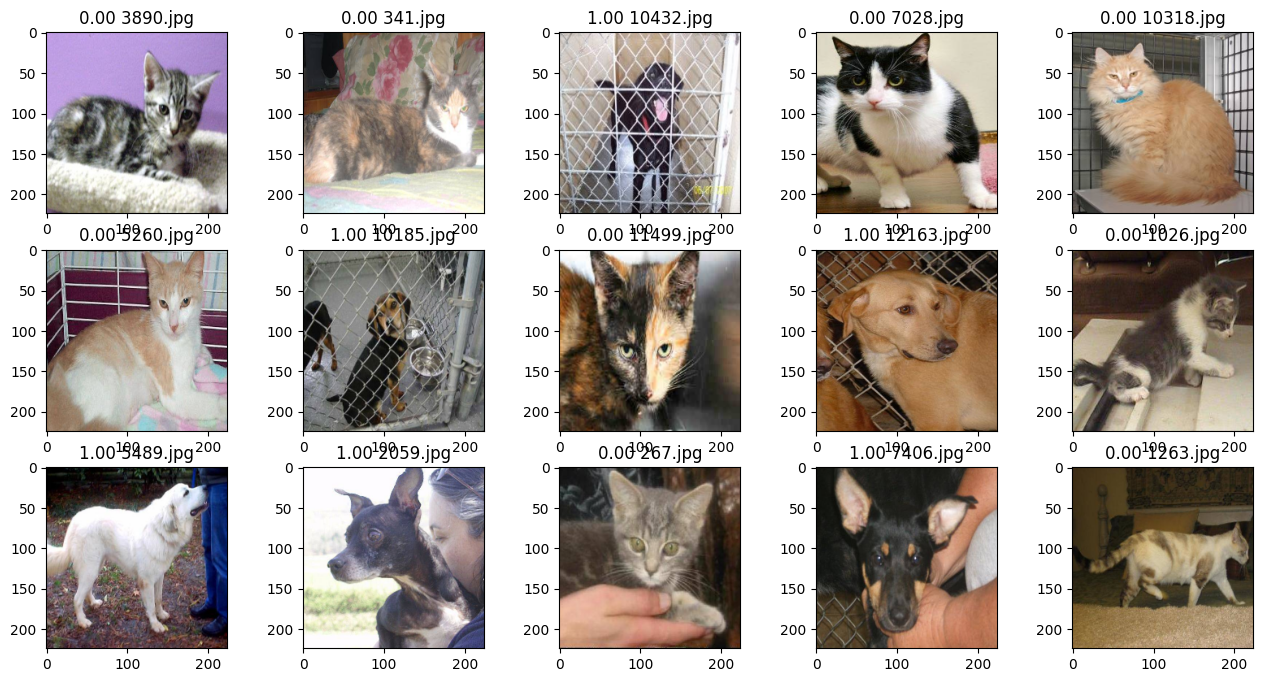

In [29]:
fig = plt.figure(figsize=(16, 8))

for i, (path, score) in enumerate(zip(test_files[:15], test_pred_int[:15]), 1):

    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)


## Готовим данные для отправки

In [30]:
object_numbers = []
for i, p in enumerate(test_files, 1):
  object_numbers.append(p.split('/')[-1].split('.')[0])

In [31]:
len(object_numbers)

12500

In [32]:
object_numbers = np.array(object_numbers, dtype=int)

In [33]:
import csv
with open('/content/output/cats_and_dogs__submission.csv', 'w') as dst:
    writer = csv.writer(dst)
    writer.writerow(['id','label'])
    for i, p in sorted(zip(object_numbers, test_pred_int)):
        writer.writerow((i, p))